<a href="https://colab.research.google.com/github/piyamantha93/ABC_Lab/blob/master/Cirrhosis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from numpy import nan as NA
from sklearn.model_selection import GridSearchCV


In [132]:

data = pd.read_csv('/content/drive/MyDrive/Data/cirrhosis.csv')


In [30]:
data


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,D,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,C,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,C,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,C,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


In [133]:
data=data.drop("ID",axis=1)

In [134]:
data.isnull().sum()


N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [33]:
data.isnull().sum()/data.shape[0]*100

N_Days            0.000000
Status            0.000000
Drug             25.358852
Age               0.000000
Sex               0.000000
Ascites          25.358852
Hepatomegaly     25.358852
Spiders          25.358852
Edema             0.000000
Bilirubin         0.000000
Cholesterol      32.057416
Albumin           0.000000
Copper           25.837321
Alk_Phos         25.358852
SGOT             25.358852
Tryglicerides    32.535885
Platelets         2.631579
Prothrombin       0.478469
Stage             1.435407
dtype: float64

In [102]:
data.duplicated().sum()

0

In [103]:
for i in data.select_dtypes(include="object").columns:
  print(data[i].value_counts())
  print("***"*10)

C     232
D     161
CL     25
Name: Status, dtype: int64
******************************
D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64
******************************
F    374
M     44
Name: Sex, dtype: int64
******************************
N    288
Y     24
Name: Ascites, dtype: int64
******************************
Y    160
N    152
Name: Hepatomegaly, dtype: int64
******************************
N    222
Y     90
Name: Spiders, dtype: int64
******************************
N    354
S     44
Y     20
Name: Edema, dtype: int64
******************************


In [36]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,418.0,1917.782297,1104.672992,41.00,1092.7500,1730.00,2613.50,4795.00
Age,418.0,18533.351675,3815.845055,9598.00,15644.5000,18628.00,21272.50,28650.00
Bilirubin,418.0,3.220813,4.407506,0.30,0.8000,1.40,3.40,28.00
Cholesterol,284.0,369.510563,231.944545,120.00,249.5000,309.50,400.00,1775.00
Albumin,418.0,3.497440,0.424972,1.96,3.2425,3.53,3.77,4.64
Copper,310.0,97.648387,85.613920,4.00,41.2500,73.00,123.00,588.00
Alk_Phos,312.0,1982.655769,2140.388824,289.00,871.5000,1259.00,1980.00,13862.40
SGOT,312.0,122.556346,56.699525,26.35,80.6000,114.70,151.90,457.25
Tryglicerides,282.0,124.702128,65.148639,33.00,84.2500,108.00,151.00,598.00
Platelets,407.0,257.024570,98.325585,62.00,188.5000,251.00,318.00,721.00


In [37]:
data.describe(include="object")

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
count,418,312,418,312,312,312,418
unique,3,2,2,2,2,2,3
top,C,D-penicillamine,F,N,Y,N,N
freq,232,158,374,288,160,222,354


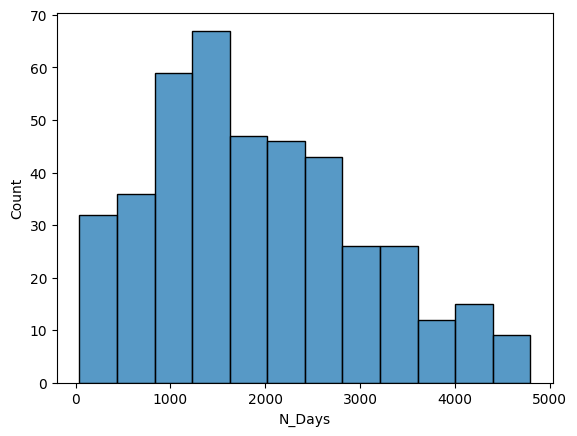

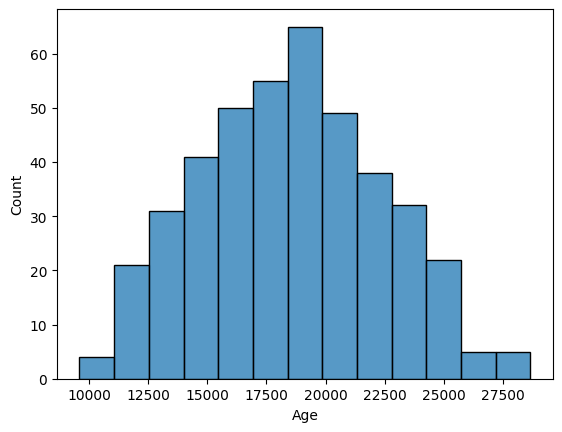

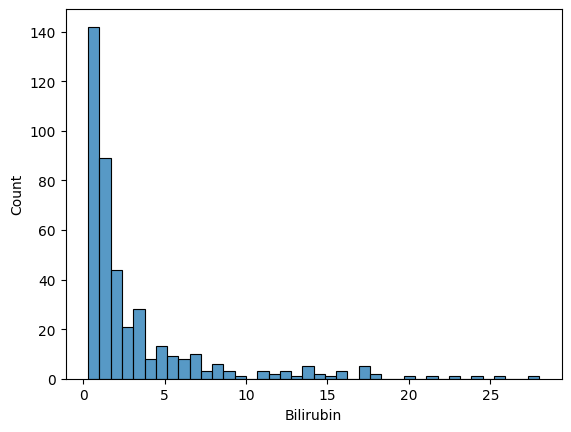

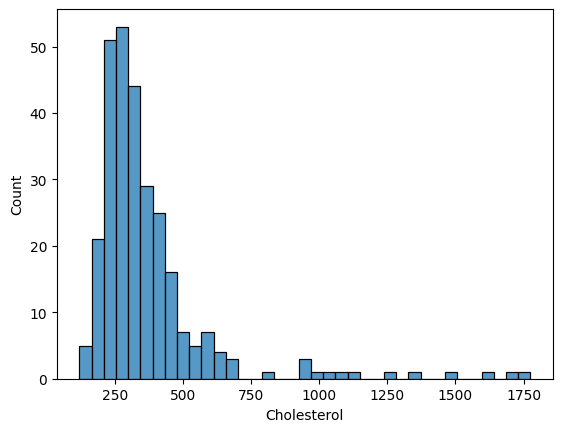

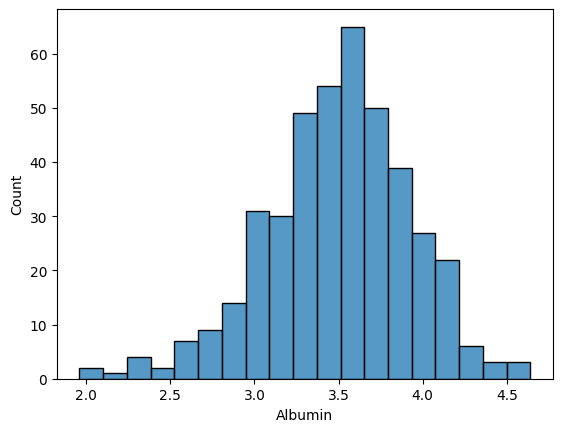

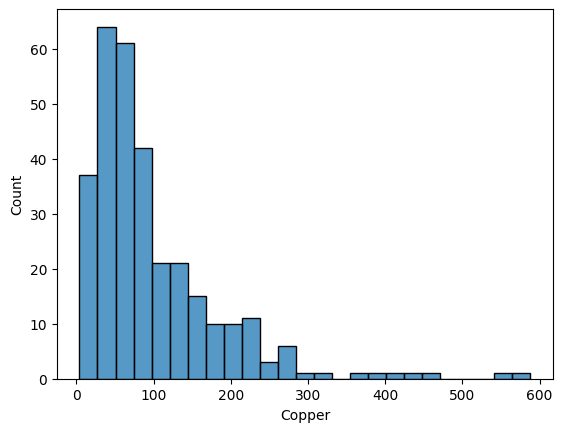

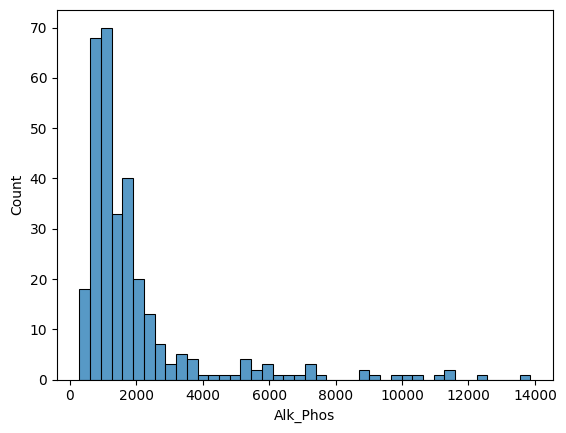

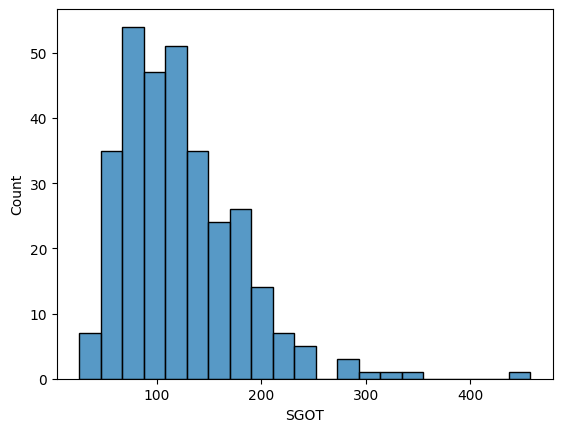

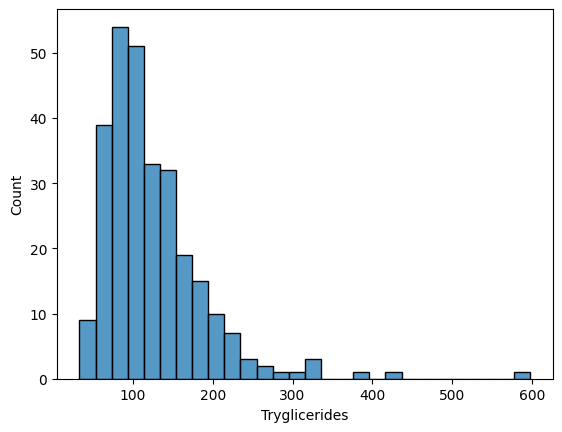

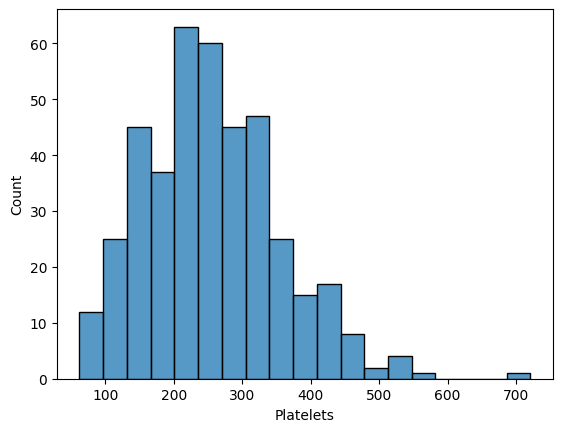

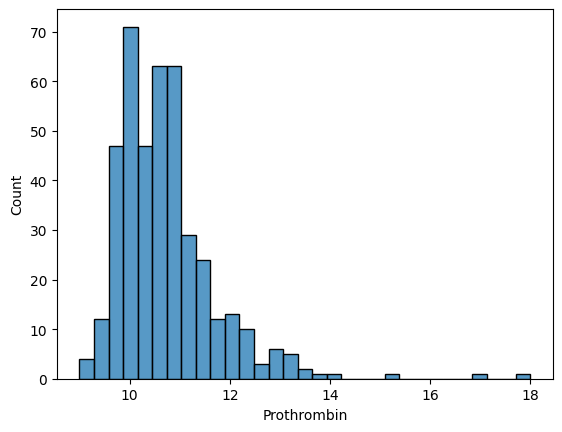

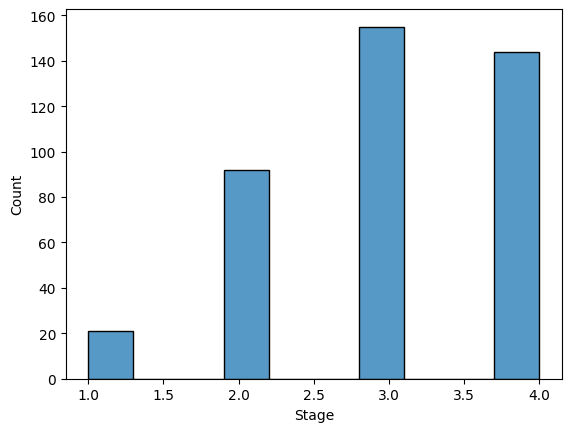

In [38]:
for i in data.select_dtypes(include="number").columns:
  sns.histplot(data=data,x=i )
  plt.show()


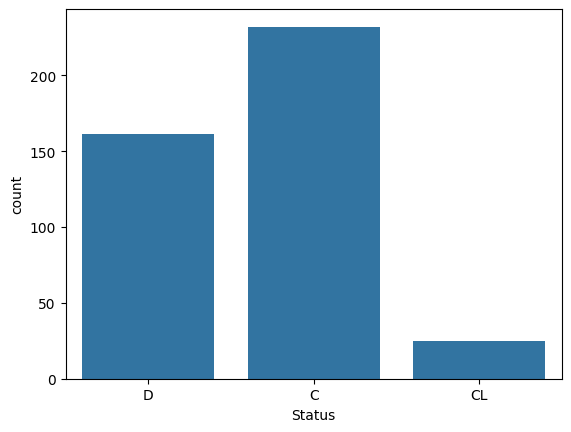

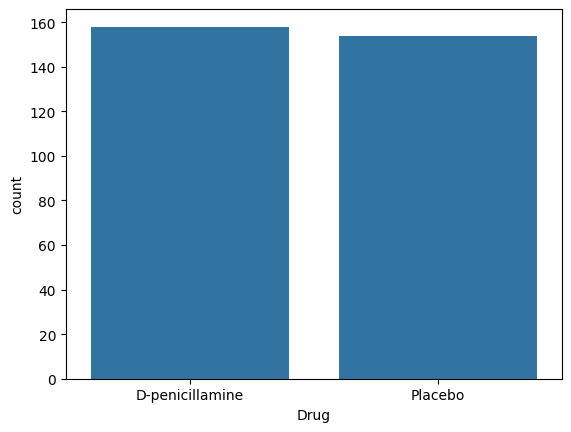

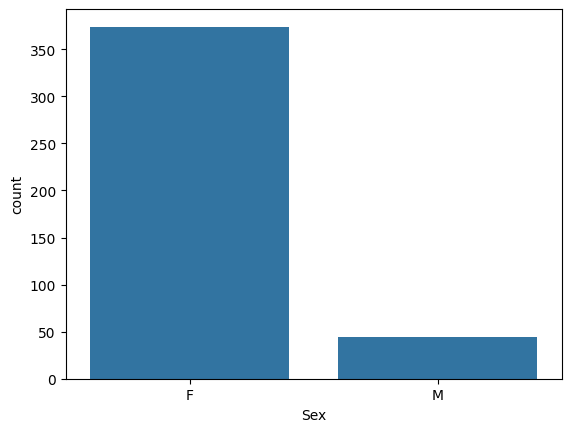

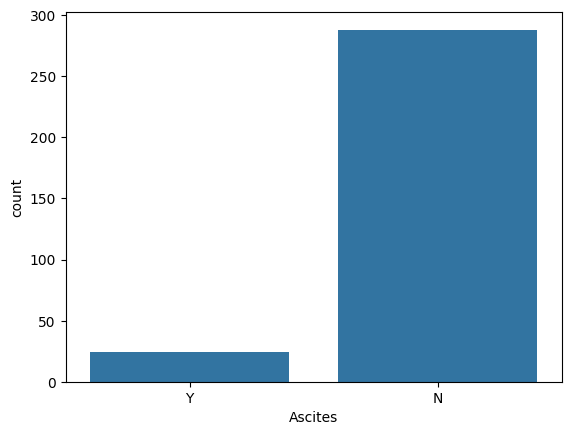

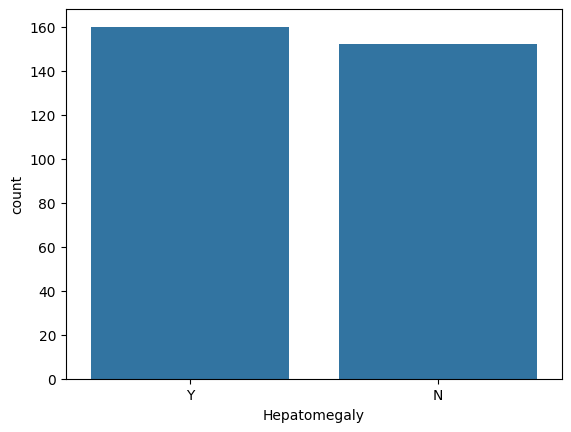

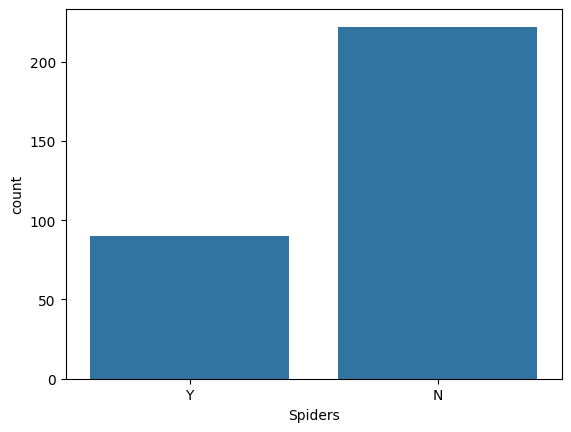

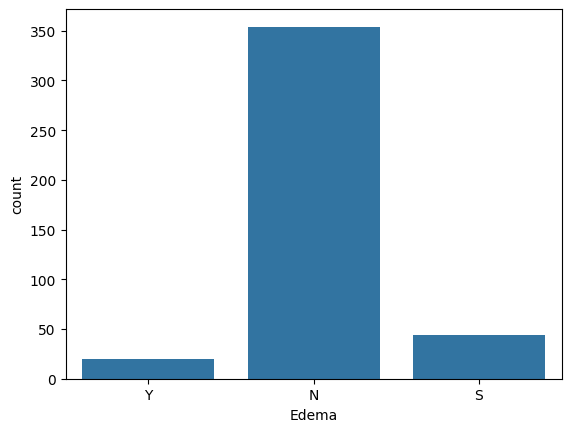

In [39]:
for i in data.select_dtypes(include="object").columns:
 sns.countplot(data=data,x=i )
 plt.show()

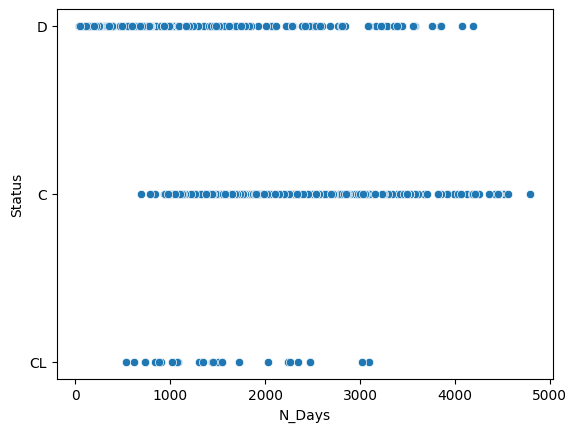

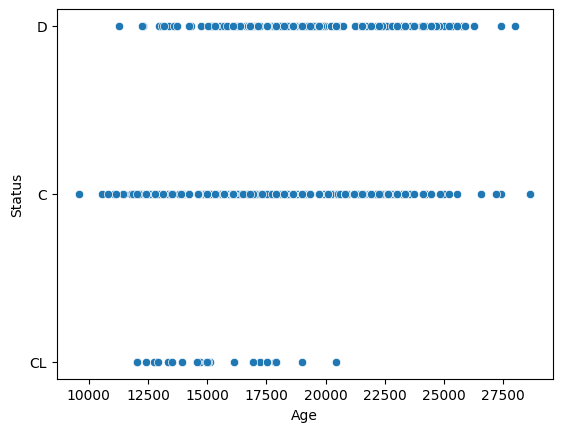

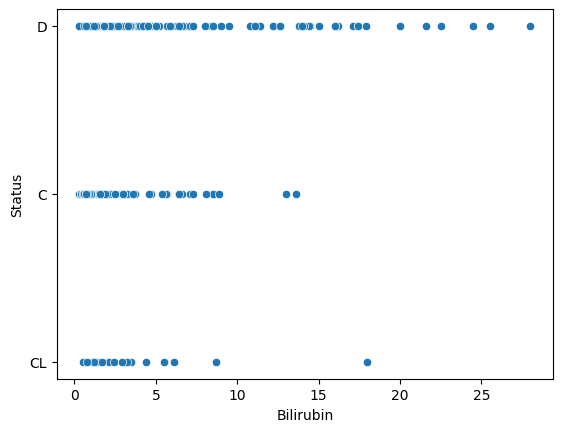

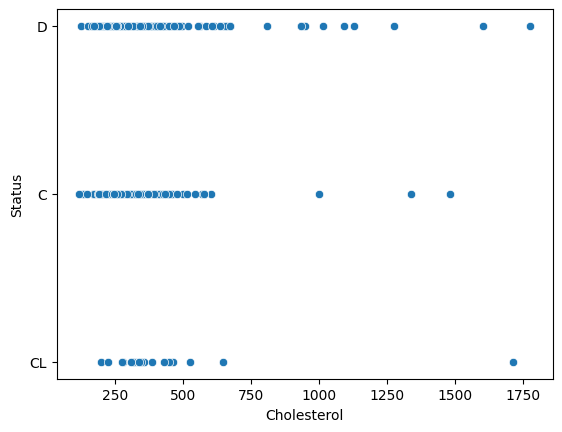

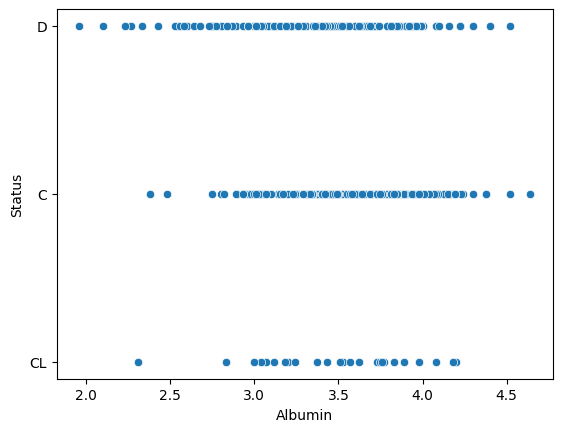

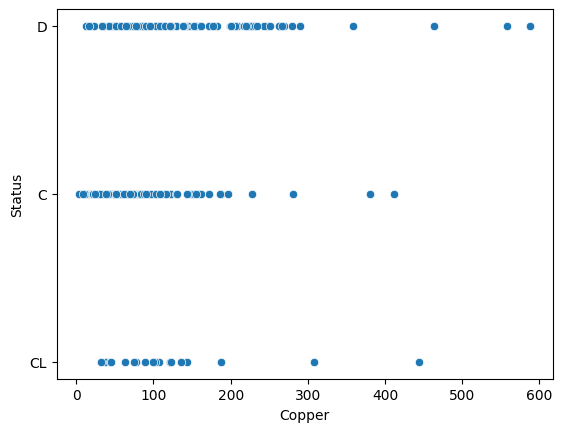

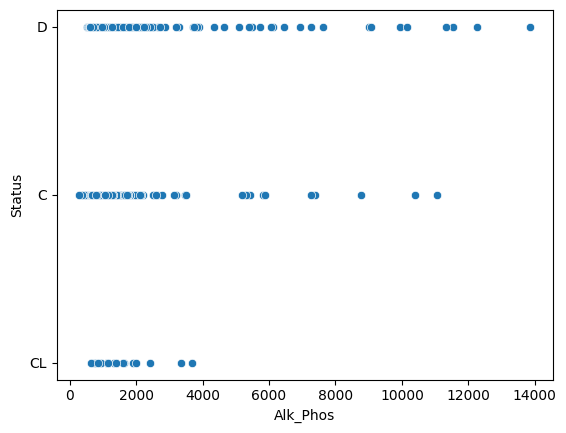

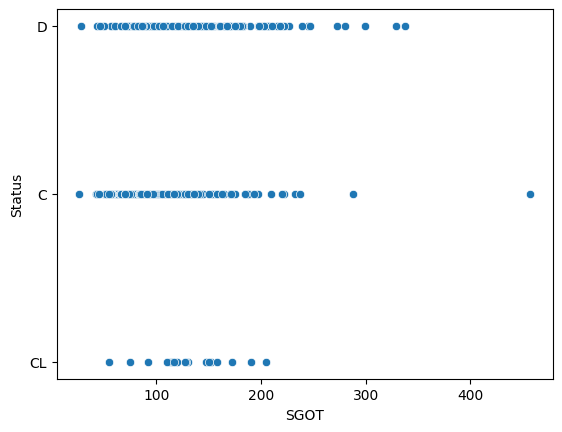

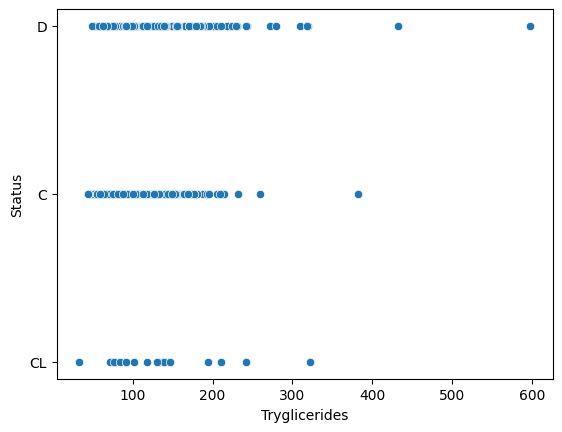

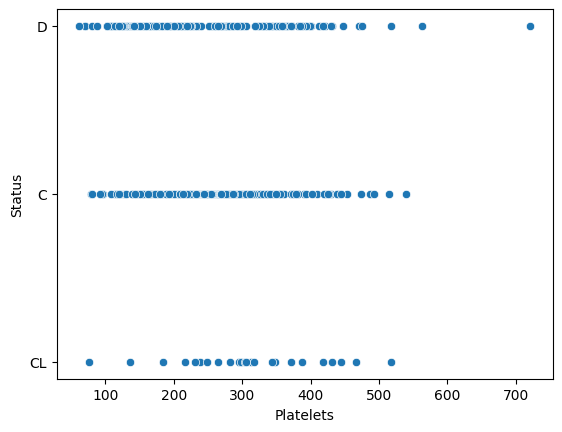

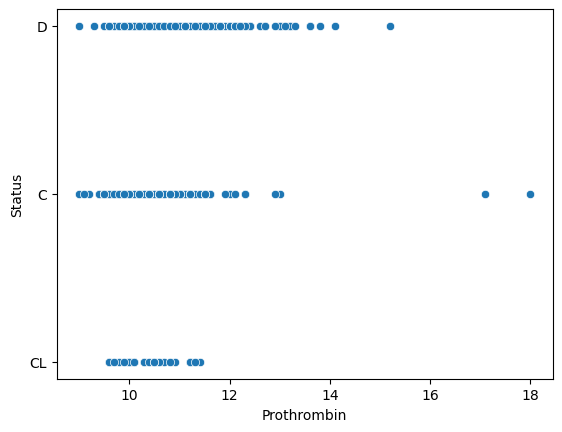

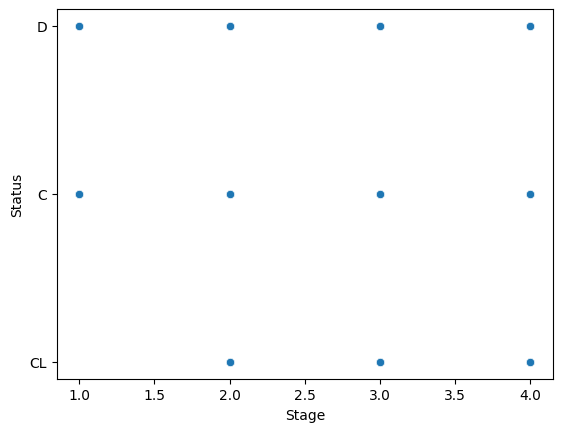

In [40]:
for i in ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage']:
       sns.scatterplot(data=data,x=i,y='Status')
       plt.show()

In [135]:
cat_columns = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]


In [136]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in cat_columns:
    data[col] = label_encoder.fit_transform(data[col])


In [137]:
from sklearn.impute import KNNImputer
impute=KNNImputer()


In [138]:
# cat_columns = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]

for column in cat_columns:
    most_frequent_category = data[column].mode()[0]
    data[column].fillna(most_frequent_category, inplace=True)

In [139]:
for i in data.select_dtypes(include="number").columns:
  data[i]=impute.fit_transform(data[[i]])

In [140]:
for i in data.select_dtypes(include="category").columns:
  data[i]=impute.fit_transform(data[[i]])

In [141]:
data.isnull().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [ ]:
# data['Drug'] = data['Drug'].str.replace('-', '')

In [91]:
s=data.select_dtypes(include="number").corr()

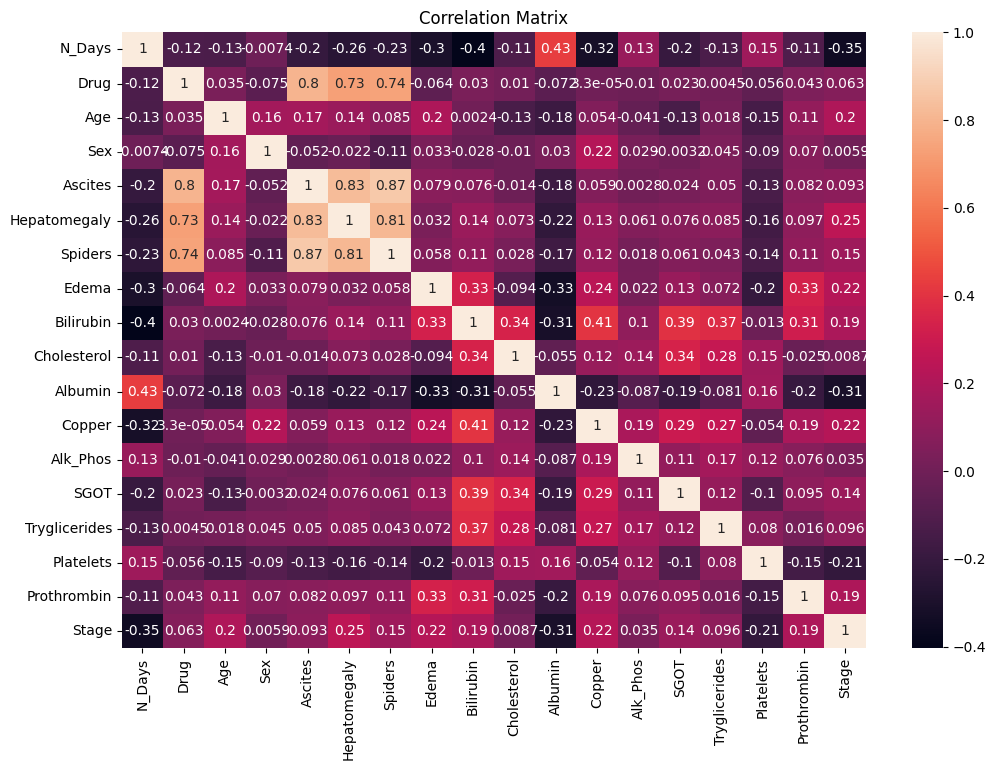

In [49]:
plt.figure(figsize=(12, 8))
sns.heatmap(s, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [142]:
from sklearn.model_selection import train_test_split

Y = data.Status.copy()
data = data.drop(['Status'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size = 0.2, random_state=42)

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# # Assuming 'df' is your DataFrame and 'Drug' is the categorical column
# label_encoder = LabelEncoder()
# data['Drug_encoded'] = label_encoder.fit_transform(data['Drug'])


In [143]:
# categorical_cols = data.select_dtypes(include=['object', 'bool']).columns
numerical_cols = [ 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

In [144]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [145]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, cat_columns)])

In [146]:
# Define the model
model= RandomForestClassifier(n_estimators=100, random_state=42)

# Create a processing and modeling pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])


In [147]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, Y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=95, random_state=45, criterion="gini",max_depth=15, min_samples_leaf=1, min_samples_split= 2,max_features='auto')
rf.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=15, max_features='auto', n_estimators=95,
                       random_state=45)

In [148]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8452380952380952
Classification Report:
              precision    recall  f1-score   support

           C       0.82      0.93      0.87        44
          CL       0.00      0.00      0.00         4
           D       0.88      0.83      0.86        36

    accuracy                           0.85        84
   macro avg       0.57      0.59      0.58        84
weighted avg       0.81      0.85      0.82        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [240]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [188]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, Y, test_size=0.2, random_state=42)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5,)
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [ ]:
y_predKNeighborsClassifier = knn.predict(X_test)
accuracyKNeighborsClassifier = accuracy_score(y_test, y_predKNeighborsClassifier)
reportKNeighborsClassifier = classification_report(y_test, y_predKNeighborsClassifier)

print(f"Accuracy: {accuracyKNeighborsClassifier}")
print("Classification Report:")
print(reportKNeighborsClassifier)


Accuracy: 0.7142857142857143
Classification Report:
              precision    recall  f1-score   support

           C       0.67      0.89      0.76        44
          CL       0.00      0.00      0.00         4
           D       0.81      0.58      0.68        36

    accuracy                           0.71        84
   macro avg       0.49      0.49      0.48        84
weighted avg       0.70      0.71      0.69        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [189]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, Y, test_size=0.2, random_state=42)
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier( max_depth=4,)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [ ]:
y_predDecisionTreeClassifier = clf.predict(X_test)
accuracyDecisionTreeClassifier = accuracy_score(y_test, y_predDecisionTreeClassifier)
reportDecisionTreeClassifier = classification_report(y_test, y_predDecisionTreeClassifier)

print(f"Accuracy: {accuracyDecisionTreeClassifier}")
print("Classification Report:")
print(reportDecisionTreeClassifier)


Accuracy: 0.7619047619047619
Classification Report:
              precision    recall  f1-score   support

           C       0.78      0.86      0.82        44
          CL       0.00      0.00      0.00         4
           D       0.74      0.72      0.73        36

    accuracy                           0.76        84
   macro avg       0.51      0.53      0.52        84
weighted avg       0.72      0.76      0.74        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [190]:
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)





GaussianNB()

In [ ]:
y_predGaussianNB = gnb.predict(X_test)
accuracyGaussianNB = accuracy_score(y_test, y_predGaussianNB)
reportGaussianNB = classification_report(y_test, y_predGaussianNB)

print(f"Accuracy: {accuracyGaussianNB}")
print("Classification Report:")
print(reportGaussianNB)


Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           C       0.74      0.89      0.80        44
          CL       0.00      0.00      0.00         4
           D       0.83      0.67      0.74        36

    accuracy                           0.75        84
   macro avg       0.52      0.52      0.51        84
weighted avg       0.74      0.75      0.74        84



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(n_estimators=96, learning_rate=1.0, max_depth=4, random_state=45)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=4, n_estimators=96,
                           random_state=45)

In [ ]:
y_predGradientBoostingClassifier = gbm.predict(X_test)
accuracyGradientBoostingClassifier = accuracy_score(y_test, y_predGradientBoostingClassifier)
reportGradientBoostingClassifier = classification_report(y_test, y_predGradientBoostingClassifier)

print(f"Accuracy: {accuracyGradientBoostingClassifier}")
print("Classification Report:")
print(reportGradientBoostingClassifier)


Accuracy: 0.8571428571428571
Classification Report:
              precision    recall  f1-score   support

           C       0.82      0.95      0.88        44
          CL       1.00      0.25      0.40         4
           D       0.91      0.81      0.85        36

    accuracy                           0.86        84
   macro avg       0.91      0.67      0.71        84
weighted avg       0.87      0.86      0.85        84



In [ ]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', C=4, random_state=45)
svm.fit(X_train, y_train)



SVC(C=4, kernel='linear', random_state=45)

In [ ]:
y_SVC = svm.predict(X_test)
accuracySVC = accuracy_score(y_test, y_SVC)
reportSVC = classification_report(y_test, y_SVC)

print(f"Accuracy: {accuracySVC}")
print("Classification Report:")
print(reportSVC)

Accuracy: 0.7857142857142857
Classification Report:
              precision    recall  f1-score   support

           C       0.79      0.84      0.81        44
          CL       0.00      0.00      0.00         4
           D       0.78      0.81      0.79        36

    accuracy                           0.79        84
   macro avg       0.52      0.55      0.54        84
weighted avg       0.75      0.79      0.77        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.linear_model import SGDClassifier

X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

sgd_clf = SGDClassifier(loss='log', penalty='l1', max_iter=1000, tol=1e-3, random_state=42)

sgd_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGDClassifier(loss='log', penalty='l1', random_state=42)

In [ ]:
y_SGDClassifier = sgd_clf.predict(X_test)
accuracySGDClassifier = accuracy_score(y_test, y_SGDClassifier)
reportSGDClassifier = classification_report(y_test, y_SGDClassifier)

print(f"Accuracy: {accuracySGDClassifier}")
print("Classification Report:")
print(reportSGDClassifier)

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           C       0.69      0.98      0.81        44
          CL       0.00      0.00      0.00         4
           D       0.91      0.56      0.69        36

    accuracy                           0.75        84
   macro avg       0.53      0.51      0.50        84
weighted avg       0.75      0.75      0.72        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [191]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, Y, test_size=0.2, random_state=42)



In [192]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier(random_state=42)

In [197]:
search_space= {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=search_space, cv=5, verbose=2, n_jobs=-1)

In [198]:
from sklearn.model_selection import GridSearchCV
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             verbose=2)

In [199]:
print("Best Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

Best Parameters: {'bootstrap': True, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=6, max_features='auto', min_samples_leaf=4,
                       n_estimators=50)

In [200]:
from sklearn.metrics import classification_report, accuracy_score

predictions = best_rf.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           C       0.76      0.89      0.82        44
          CL       0.00      0.00      0.00         4
           D       0.82      0.75      0.78        36

    accuracy                           0.79        84
   macro avg       0.53      0.55      0.53        84
weighted avg       0.75      0.79      0.77        84

Accuracy: 0.7857142857142857


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [149]:
test = pd.read_csv('/content/drive/MyDrive/Data/test.csv')

In [150]:
test

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13171,2870,Placebo,12279,F,N,N,N,N,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0
5267,13172,1770,Placebo,24803,F,N,N,N,N,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0
5268,13173,3707,D-penicillamine,16990,F,N,Y,N,N,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0
5269,13174,1216,Placebo,11773,F,N,N,N,N,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0


In [151]:
cat_columns = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]

In [152]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in cat_columns:
    test[col] = label_encoder.fit_transform(test[col])

In [153]:
from sklearn.impute import KNNImputer
impute=KNNImputer()


In [154]:


for column in cat_columns:
    most_frequent_category = data[column].mode()[0]
    data[column].fillna(most_frequent_category, inplace=True)

In [155]:
for i in data.select_dtypes(include="number").columns:
  data[i]=impute.fit_transform(data[[i]])

In [156]:
for i in data.select_dtypes(include="category").columns:
  data[i]=impute.fit_transform(data[[i]])

In [125]:
# test = test.drop('id', axis=1)

In [157]:
test.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,0,19724,0,0,1,0,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,1
1,7906,2468,0,14975,0,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,1
2,7907,51,1,13149,0,0,1,0,2,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,3
3,7908,2330,0,20510,0,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,1
4,7909,1615,0,21904,0,0,1,0,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,0


In [158]:
test.isnull().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [161]:
y_test_pred = rf.predict(test.drop('id', axis=1))
prob2 = rf.predict_proba(test.drop('id', axis=1))
submission = pd.DataFrame(prob2, columns=['Status_C', 'Status_CL', 'Status_D'])
submission['id'] = test['id']
submission = submission[['id', 'Status_C', 'Status_CL', 'Status_D']]
submission.to_csv('submissionRandomForest.csv', index=False)

In [174]:
import pickle
import h5py

In [176]:
pickle.dump(rf,open('/content/drive/MyDrive/Data/RF.h5', 'wb'))